In [811]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
from torch import optim

In [812]:
trainSize = 0.8
testSize = 0.2
torch.version.__version__

'1.10.2'


Problem 1 (20 pts):

In our temperature prediction example, let’s change our model to a non-linear system. Consider the following description for our model:

w2 * t_u ** 2 + w1 * t_u + b.

1.a Modify the training loop properly to accommodate this redefinition. 

1.b Use 5000 epochs for your training. Explore different learning rates from 0.1 to 0.0001 (you need four separate trainings). Report your loss for every 500 epochs per training.

1.c Pick the best non-linear model and compare your final best loss against the linear model that we did during the lecture. For this, visualize the non-linear model against the linear model over the input dataset, as we did during the lecture. Is the actual result better or worse than our baseline linear model?


In [813]:
#from slide 3, temperature data
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
#t_c = normalize(torch.tensor(t_c), p=1.0, dim = 0)
#t_u = normalize(torch.tensor(t_u), p=1.0, dim = 0)
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)
t_un = 0.05 * t_u


w = torch.tensor([1.0,1.0])
b = torch.tensor([0.0])

In [814]:
def model (t_u, w, b):
    return w[0] * t_u ** 2 + w[1] * t_u + b

In [815]:
def loss_fn(t_p, t_c):
    squared_diffs = torch.square(torch.sub(t_p, t_c, alpha = 1))
    return squared_diffs.mean()

In [816]:
delta = 0.1
loss_delta_w = (loss_fn(model(t_un, w + delta, b), t_c) - loss_fn(model(t_un, w - delta, b), t_c)) / (2.0 * delta)

In [817]:
learning_rate = 1e-2
w = w - learning_rate * loss_delta_w

In [818]:
loss_delta_b = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_delta_b

In [819]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

#d/dw w2*tu^2 + w1*tu + b = 2*w2*tu + tu
def dmodel_dw(t_u, w, b):
    return 2*w[0]*t_u + t_u

#d/db w2*tu^2 + w1*tu + b = 1
def dmodel_db(t_u, w, b):
    return 1.0

In [820]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw1 = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_dw2 = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw1.sum(), dloss_dw2.sum(), dloss_db.sum()])

In [821]:
def training_loop(n_epochs, lr, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w[1], w[0], b = params
        
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)
        
        params = params - lr * grad
        if (epoch % 500 == 0):
            print ('Epoch %d, Loss %f' % (epoch, float(loss)))
    
    return params

In [822]:
training_loop(n_epochs = 5000, lr = 1e-1, params = torch.tensor([1.0,1.0,0.0]), t_u = t_un, t_c = t_c)

Epoch 500, Loss nan
Epoch 1000, Loss nan
Epoch 1500, Loss nan
Epoch 2000, Loss nan
Epoch 2500, Loss nan
Epoch 3000, Loss nan
Epoch 3500, Loss nan
Epoch 4000, Loss nan
Epoch 4500, Loss nan
Epoch 5000, Loss nan


tensor([nan, nan, nan])

In [823]:
training_loop(n_epochs = 5000, lr = 1e-2, params = torch.tensor([1.0,1.0,0.0]), t_u = t_un, t_c = t_c)

Epoch 500, Loss 14.905792
Epoch 1000, Loss 14.919845
Epoch 1500, Loss 14.919877
Epoch 2000, Loss 14.919877
Epoch 2500, Loss 14.919877
Epoch 3000, Loss 14.919877
Epoch 3500, Loss 14.919877
Epoch 4000, Loss 14.919877
Epoch 4500, Loss 14.919877
Epoch 5000, Loss 14.919877


tensor([ 0.8937,  0.8937, -1.8435])

In [824]:
params = training_loop(n_epochs = 5000, lr = 1e-3, params = torch.tensor([1.0,1.0,0.0]), t_u = t_un, t_c = t_c)

Epoch 500, Loss 9.636432
Epoch 1000, Loss 7.903916
Epoch 1500, Loss 6.577419
Epoch 2000, Loss 5.562541
Epoch 2500, Loss 4.786726
Epoch 3000, Loss 4.194201
Epoch 3500, Loss 3.742140
Epoch 4000, Loss 3.397652
Epoch 4500, Loss 3.135494
Epoch 5000, Loss 2.936308


In [825]:
training_loop(n_epochs = 5000, lr = 1e-4, params = torch.tensor([1.0,1.0,0.0]), t_u = t_un, t_c = t_c)

Epoch 500, Loss 11.638963
Epoch 1000, Loss 11.391587
Epoch 1500, Loss 11.150748
Epoch 2000, Loss 10.916253
Epoch 2500, Loss 10.687913
Epoch 3000, Loss 10.465536
Epoch 3500, Loss 10.249030
Epoch 4000, Loss 10.038197
Epoch 4500, Loss 9.832887
Epoch 5000, Loss 9.633007


tensor([ 1.2221,  1.2221, -0.8447])

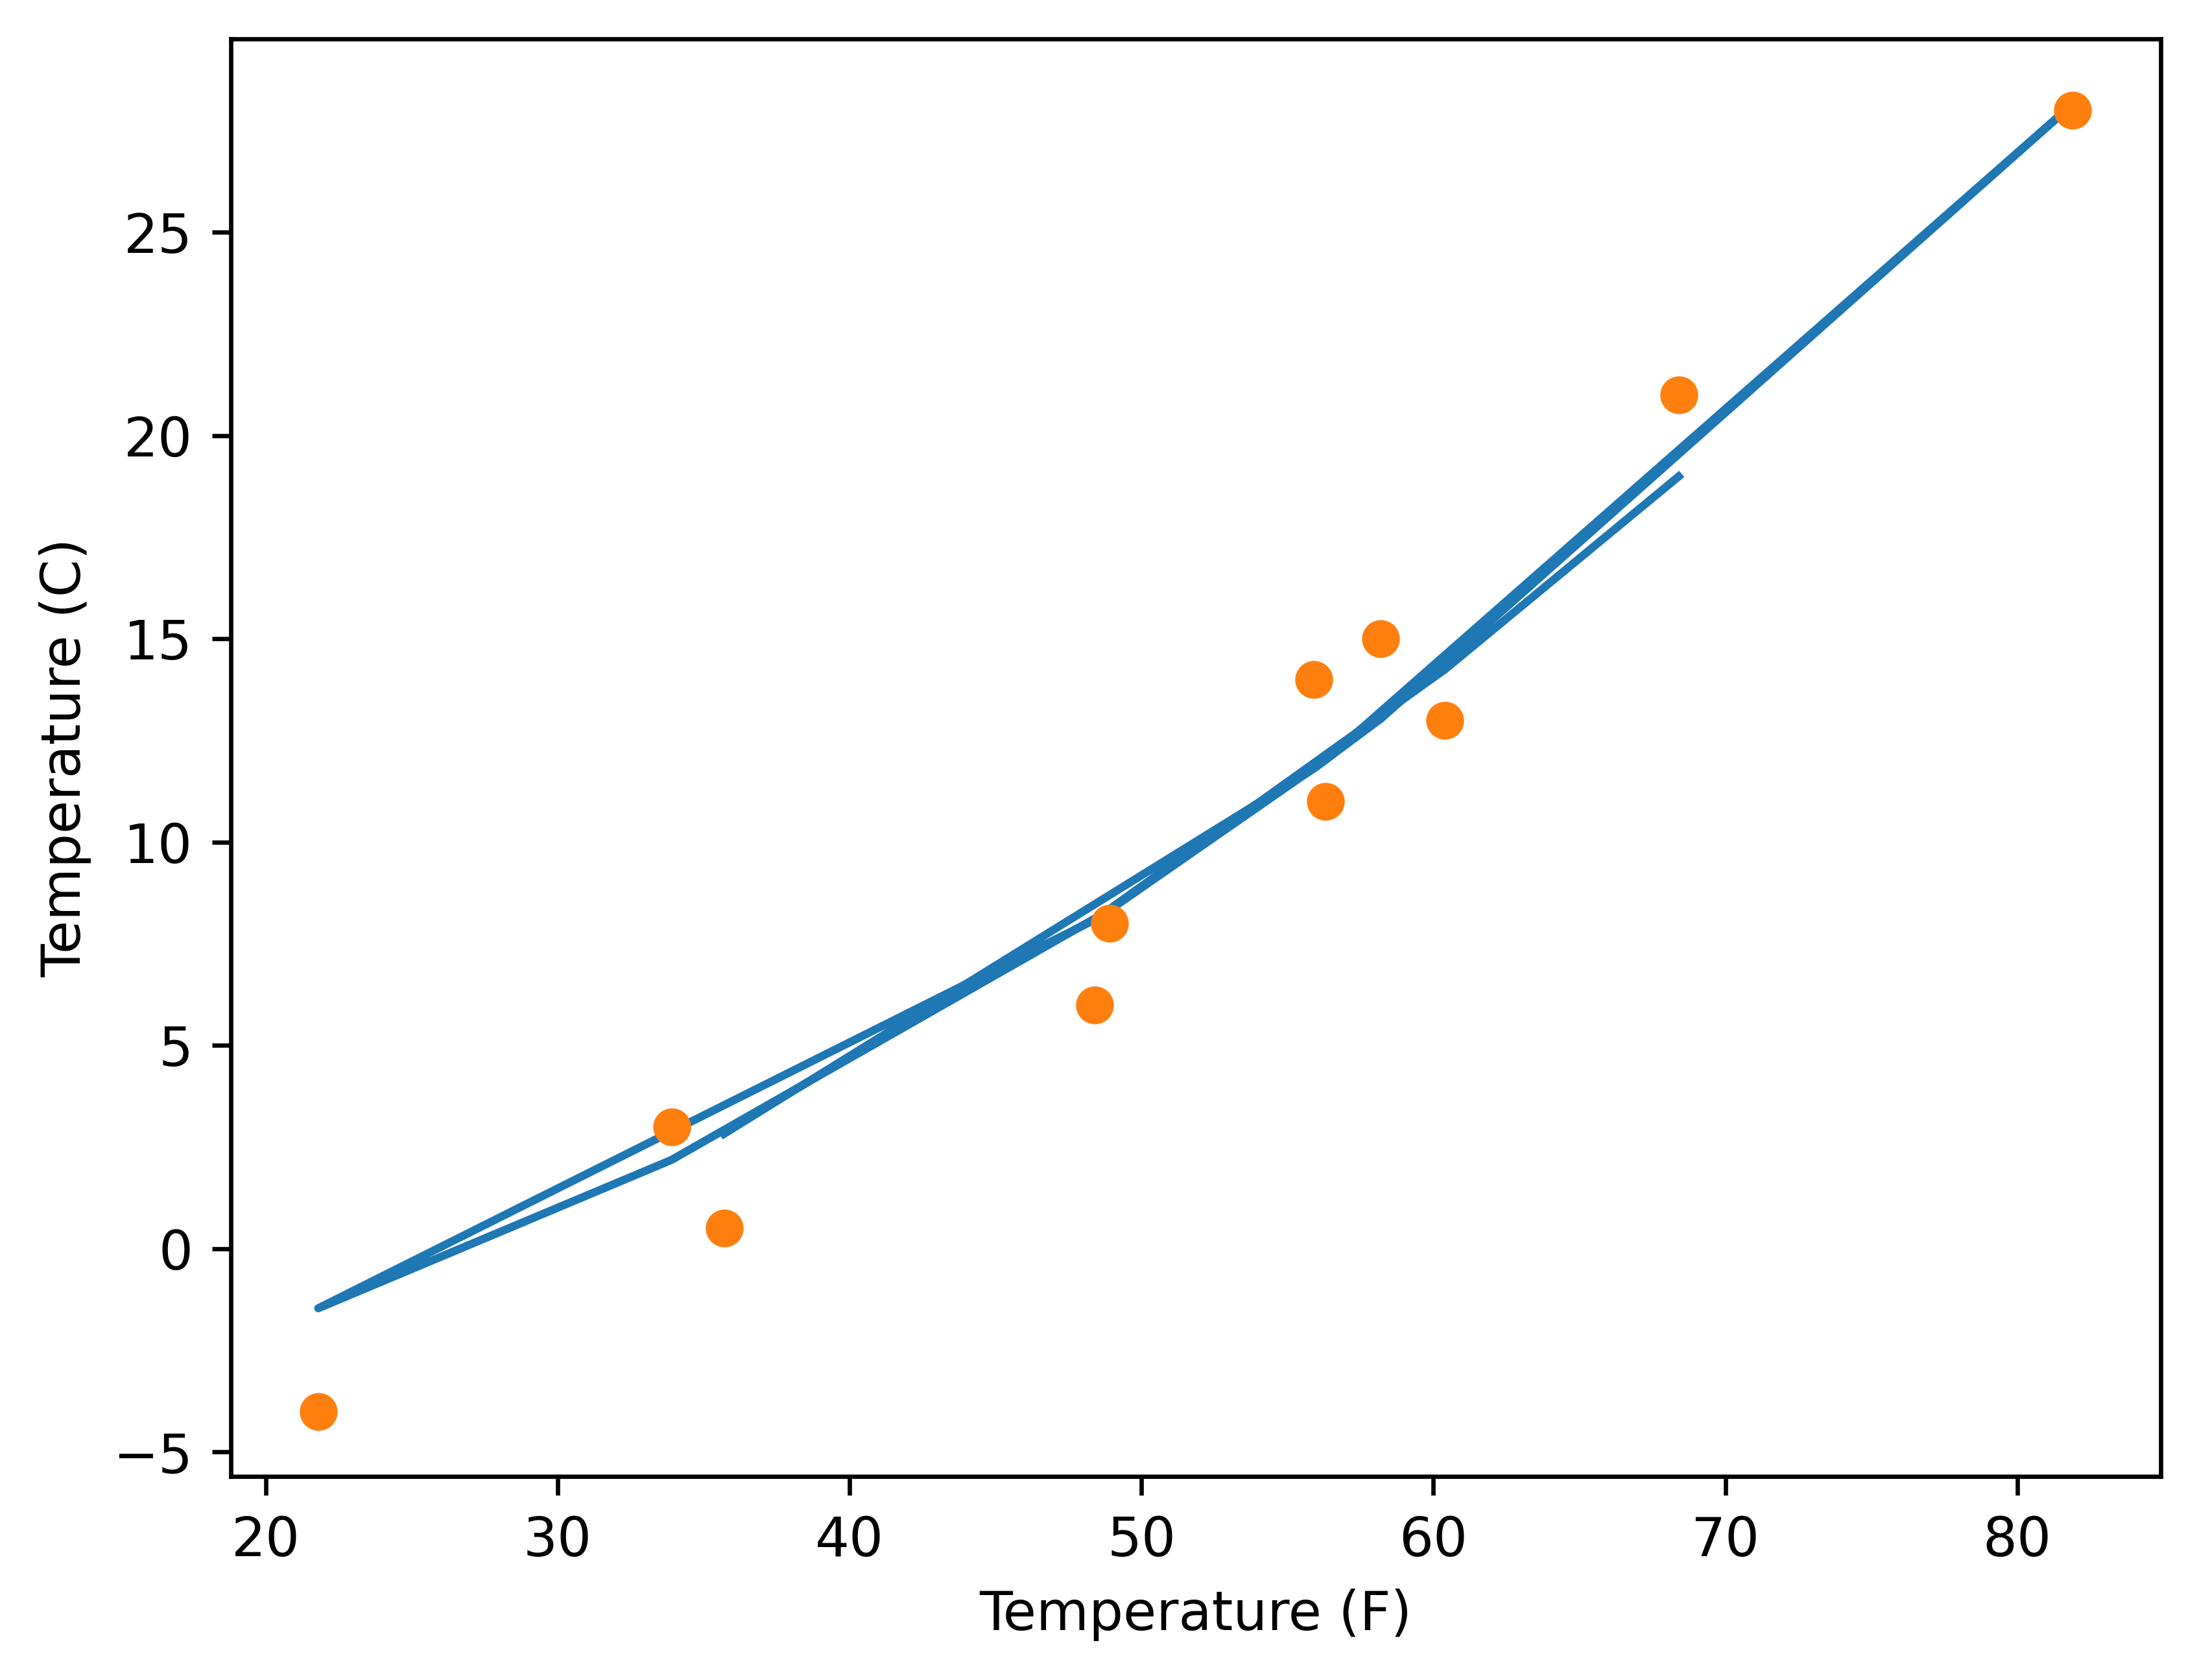

In [826]:
%matplotlib inline
from matplotlib import pyplot as plt


t_p = model(t_un, ([params[0],params[1]]), params[2])

fig = plt.figure(dpi = 600)
plt.xlabel("Temperature (F)")
plt.ylabel("Temperature (C)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')



Problem 2 (30 pts):

2.a. Develop preprocessing and a training loop to train a linear regression model that predicts housing price based on the following input variables:

area, bedrooms, bathrooms, stories, parking

For this, you need to use the housing dataset. For training and validation use 80% (training) and 20% (validation) split. Identify the best parameters for your linear regression model, based on the above input variables. In this case, you will have six parameters:

U=W5*X5 + W4*X4 + W3*X3 + W2*X2 + W1*X1 + B

2.b Use 5000 epochs for your training. Explore different learning rates from 0.1 to 0.0001 (you need four separate trainings). Report your loss and validation accuracy for every 500 epochs per each training. Pick the best linear model.


In [827]:
housing = pd.read_csv('https://raw.githubusercontent.com/pcur/ECGR-4105/main/Homework%201/Housing.csv')

Y_house = housing.values[:,0]
t_c = torch.tensor(housing.values[:,0].tolist())

area = torch.tensor(housing.values[:,1].reshape(len(Y_house),1).tolist())
rooms = torch.tensor(housing.values[:,2].reshape(len(Y_house),1).tolist())
bath = torch.tensor(housing.values[:,3].reshape(len(Y_house),1).tolist())
floor = torch.tensor(housing.values[:,4].reshape(len(Y_house),1).tolist())
park = torch.tensor(housing.values[:,10].reshape(len(Y_house),1).tolist())

t_u = torch.stack((area,rooms,bath,floor,park))

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([1, 2, 0, 3]), tensor([4]))

In [828]:
train_t_c = t_c[train_indices]
train_t_u = t_u[train_indices]

val_t_c = t_c[val_indices]
val_t_u = t_u[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

w_n = torch.zeros(5)

In [829]:
def model2 (t_u, w1, w2,w3,w4,w5, b):
    return t_u*w5 + t_u*w4 + t_u*w3 + t_u*w2 + t_u *w1 + b

In [830]:
def training_loop2 (n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1,n_epochs + 1):
        train_t_p = model2(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model2(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                 f" Validation loss {val_loss.item():.4f}")
    return params

In [831]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss

In [832]:
params = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.SGD([params], lr = learning_rate)
training_loop2(n_epochs = 500, 
              optimizer = optimizer, 
             params = params, 
              train_t_u = train_t_un, 
              val_t_u = val_t_un, 
              train_t_c = train_t_c, 
              val_t_c = val_t_c )


Epoch 500, Training loss nan, Validation loss nan


tensor([nan, nan, nan, nan, nan, nan], requires_grad=True)


Problem 3 (50 pts):

3.a Build a fully connected neural network for the housing dataset you did in previous problem. For training and validation use 80% (training) and 20% (validation) split. For this part, only use one hidden layer with 8 nodes. Train your network for 200 epochs. Report your training time, training loss, and evaluation accuracy after 200 epochs. Analyze your results in your report. Make sure to submit your code by providing the GitHub URL of your course repository for this course. (15pts)

3.b Extend your network with two more additional hidden layers, like the example we did in lecture. Train your network for 200 epochs. Report your training time, training loss, and evaluation accuracy after 200 epochs. Analyze your results in your report. Make sure to submit your code by providing the GitHub URL of your course repository for this course. Analyze your results in your report and compare your model size and accuracy over the baseline implementation in Problem1. a. Do you see any over-fitting? Make sure to submit your code by providing the GitHub URL of your course repository for this course. (25pts)

In [844]:
def training_loop3(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1,n_epochs +1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train.float(), t_c_train.float())
        t_p_val = model(t_u_val)
    
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 50 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():4f}")

In [845]:
linear_model = nn.Linear(1,1)

seq_model = nn.Sequential(
            nn.Linear(1,8),
            nn.ReLU(),
            nn.Linear(8,1))


optimizer = optim.SGD(
    seq_model.parameters(),
    lr = 1e-5)

t_c_train = train_t_c
t_un_train = train_t_un
t_c_val = val_t_c
t_un_val = val_t_un




training_loop3(
    n_epochs = 200,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch 1, Training loss 156555047600128.0000, Validation loss 130188100763648.000000
Epoch 50, Training loss 168306078121984.0000, Validation loss 140929570701312.000000
Epoch 100, Training loss 167970198257664.0000, Validation loss 140622086275072.000000
Epoch 150, Training loss 167634989481984.0000, Validation loss 140315214217216.000000
Epoch 200, Training loss 167300502126592.0000, Validation loss 140008979693568.000000


In [849]:
seq_model = nn.Sequential(
            nn.Linear(1,8),
            nn.Tanh(),
            nn.Linear(8,10),
            nn.Tanh(),
            nn.Linear(10,12),
            nn.Sigmoid(),
            nn.Linear(12,8),
            nn.ReLU(),
            nn.Linear(8,1))

training_loop3(
    n_epochs = 200,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

C:\Users\curca\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 545, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\curca\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 545, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Training loss 156555316035584.0000, Validation loss 130188100763648.000000
Epoch 50, Training loss 156555316035584.0000, Validation loss 130188100763648.000000
Epoch 100, Training loss 156555316035584.0000, Validation loss 130188100763648.000000
Epoch 150, Training loss 156555316035584.0000, Validation loss 130188100763648.000000
Epoch 200, Training loss 156555316035584.0000, Validation loss 130188100763648.000000
